# Twitter sentiment analysis

## Imports and load data

In [1]:
from searchtweets import ResultStream, gen_rule_payload, load_credentials, collect_results

# general imports
import numpy as np
import pandas as pd
import subprocess
from textblob import TextBlob
import re
import time
import datetime

# plotting and visualization
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def runCmd(cmd, run=False):
    '''
    use stdout to run command and shell=True to allow command to be entered as a string
    use rstrip() to remove carriage return and decode binary form to string. 
     '''
    if run == False:
        try:
            output_cmd = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True)
            output_cmd = output_cmd.rstrip().decode('UTF-8')
        except subprocess.CalledProccessError as e:
            print("Command", e.cmd, "returned with error code", e.returncode)
            print("setting output_cmd to empty array")
            output_cmd = []
        return output_cmd
    else:
        subprocess.Popen(cmd, stderr=subprocess.STDOUT, shell=True)
        return None

def S2_from_csv(filename):
    return pd.read_csv(filename, parse_dates=['date'], encoding='latin')

### file name

In [3]:
current_dir = ['complete_tweets/' + x for x in runCmd('ls complete_tweets/').split('\n') if '.csv' in x]
print("Data files available to load. Please select merged complete_tweet files")
for i, x in enumerate(current_dir):
    print(str(i), " ", x)
    
value_selection = input("\nPlease input file numbers separated by a space ")
#value_selection = [ int(x) for x in value_selection.split() ]
value_selection = int(value_selection)
S2 = S2_from_csv(current_dir[value_selection])

Data files available to load. Please select merged complete_tweet files
0   complete_tweets/complete_tweets_2018_01.csv
1   complete_tweets/complete_tweets_2018_02.csv
2   complete_tweets/complete_tweets_2018_03.csv
3   complete_tweets/complete_tweets_2018_04.csv
4   complete_tweets/complete_tweets_2018_05.csv
5   complete_tweets/complete_tweets_2018_06.csv
6   complete_tweets/complete_tweets_2018_07.csv
7   complete_tweets/complete_tweets_2018_08.csv
8   complete_tweets/complete_tweets_2018_09.csv
9   complete_tweets/complete_tweets_2018_10-12.csv
10   complete_tweets/complete_tweets_2018_10.csv
11   complete_tweets/complete_tweets_2018_11.csv
12   complete_tweets/complete_tweets_2018_12.csv
13   complete_tweets/complete_tweets_2018_trim.csv
14   complete_tweets/complete_tweets_2018_uncut.csv
15   complete_tweets/complete_tweets_tweets_2018-09-01_2018-09-15.csv
16   complete_tweets/tweets_2017-11-16_2017-12-31.csv
17   complete_tweets/tweets_2018-01-01_2018-01-14.csv
18   complete_twe

In [4]:
S2.iloc[100:110,:]

,date,tweets,user_name,user_screen_name,user_followers,user_friends,user_verified,user_language,retweet_count,favorite_count,rounded_hour
100,2018-01-01 23:59:58,RT @cryptodemedici: The more Bitcoin dominance...,Pumpandtrump,bitmexican,323.0,412.0,False,en,0.0,0.0,2018-01-02 00:00:00
101,2018-01-01 23:59:58,RT @bitbit_ojin: ÃÂ£ÃÂÃÂÃÂ£ÃÂÃÂÃÂ£Ã...,ÃÂ¦ÃÂ²ÃÂÃÂ§ÃÂ¸ÃÂÃÂ£ÃÂÃÂ®ÃÂ£ÃÂÃ...,xrp2018s,337.0,302.0,False,ja,0.0,0.0,2018-01-02 00:00:00
102,2018-01-01 23:59:57,RT @BenegiftGives: For #WinItWednesday enter o...,BunnyÃÂ°ÃÂÃÂÃÂÃÂ°ÃÂÃÂÃÂ¿ÃÂ°ÃÂÃ...,Bunny_ZA_GH,237.0,884.0,False,en,0.0,0.0,2018-01-02 00:00:00
103,2018-01-01 23:59:52,RT @ElixiumCrypto: Get #Shook As Fcuk With Our...,thorsten1985,rakete1967,2998.0,3596.0,False,de,0.0,0.0,2018-01-02 00:00:00
104,2018-01-01 23:59:51,You canÃÂ¢ÃÂÃÂt make this shit up!!! http...,Entrepreneur Brian Dordevic ÃÂ°ÃÂÃÂÃÂ²Ã...,briandordevic,18027.0,19790.0,False,en,0.0,0.0,2018-01-02 00:00:00
105,2018-01-01 23:59:51,RT @OneHillVentures: If this all goes as plann...,Gonzo,Bitter_Money,144.0,37.0,False,en,0.0,0.0,2018-01-02 00:00:00
106,2018-01-01 23:59:49,"Bitcoin hits $13,000 on Zimbabwe exchange Read...",blacq,blacq2,22108.0,6960.0,False,en,0.0,0.0,2018-01-02 00:00:00
107,2018-01-01 23:59:49,RT @JonErlichman: Things that didnÃÂ¢ÃÂÃÂ...,Paul Knappe,Knappe_Paul,690.0,471.0,False,nl,0.0,0.0,2018-01-02 00:00:00
108,2018-01-01 23:59:46,ÃÂ£ÃÂÃÂÃÂ¥ÃÂÃÂÃÂ¥ÃÂ¼ÃÂ·ÃÂ£ÃÂÃ...,adte9,adte9,84.0,68.0,False,ja,0.0,0.0,2018-01-02 00:00:00
109,2018-01-01 23:59:44,RT @Egon_01: Observation\n\nWhile @rogerkver i...,Dong Tao,yt8073,10.0,91.0,False,en,0.0,0.0,2018-01-02 00:00:00


## Sentiment analysis

In [5]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet, method='to_int'):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    
    textblob already has a trained analyser to work 
    with different machine learning models on 
    natural language processing.
    
    Might want to train our own model
    '''
    analysis = TextBlob(clean_tweet(tweet))
    
    # convert to integer
    if method == 'to_int':
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    elif method == 'to_float':
        return analysis.sentiment.polarity
    else:
        print('unrecognized sentiment method')
    

def sentiment_analysis(S2_sentiment):
    # We create a column with the result of the analysis:
    S2_sentiment['SA'] = np.array([ analize_sentiment(tweet, method='to_float') for tweet in S2_sentiment['tweets'] ])
    S2_sentiment['SA_int'] = np.array([ analize_sentiment(tweet, method='to_int') for tweet in S2_sentiment['tweets'] ])
    
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(S2_sentiment['tweets']) if S2_sentiment['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(S2_sentiment['tweets']) if S2_sentiment['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(S2_sentiment['tweets']) if S2_sentiment['SA'][index] < 0]

    # We print percentages:
    print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(S2_sentiment['tweets'])))
    print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(S2_sentiment['tweets'])))
    print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(S2_sentiment['tweets'])))

In [6]:
sentiment_analysis(S2)

Percentage of positive tweets: 33.81643835616438%
Percentage of neutral tweets: 55.47671232876712%
Percentage de negative tweets: 10.706849315068494%


In [7]:
S2.head()

,date,tweets,user_name,user_screen_name,user_followers,user_friends,user_verified,user_language,retweet_count,favorite_count,rounded_hour,SA,SA_int
0,2017-12-31 23:59:59,RT @TechBalt: LIVE AT 10:40PM EST- The 1 #Bitc...,Bitcoin Rhodium Official,BitcoinRh,3815.0,502.0,False,en,0.0,0.0,2018-01-01 00:00:00,0.043182,1
1,2017-12-31 23:59:58,RT @DashSquard: wall street elites have made b...,Wonkavision,stellabelle,5690.0,3995.0,False,en,0.0,0.0,2018-01-01 00:00:00,-0.400000,-1
2,2017-12-31 23:59:57,@VitalikButerin @techguilherme @DJ_Erock23 @br...,$Pickard,AlexPickard,2109.0,439.0,False,en,0.0,8.0,2018-01-01 00:00:00,0.000000,0
3,2017-12-31 23:59:55,2017 Review: The Year Cryptocurrencies Seized ...,riocard,PhlyingJinxer,116.0,181.0,False,en,0.0,0.0,2018-01-01 00:00:00,0.000000,0
4,2017-12-31 23:59:54,https://t.co/qptCbGumZA\n@Newexpressnews A do...,NewExpressNews,NewExpressNews,6529.0,4906.0,False,en,0.0,0.0,2018-01-01 00:00:00,0.000000,0


## Stacked bar chart

In [8]:
#S2['rounded_day'] = S2['date'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
S2['rounded_hour'] = S2['date'].dt.round('H')

S3_A = S2.groupby(['rounded_hour']).agg('count').reset_index()
S3 = S2.groupby(['rounded_hour', 'SA_int']).agg('count').reset_index()
S3 = S3.assign(count = S3['tweets']).loc[:,['rounded_hour', 'SA_int', 'count']]
S3_pivot = S3.pivot(index = 'rounded_hour', columns='SA_int', values='count')

S3_pivot.head()

SA_int,-1,0,1
rounded_hour,,,
2018-01-01,12,50,38
2018-01-02,10,50,40
2018-01-03,13,47,40
2018-01-04,12,43,45
2018-01-05,19,49,32


In [9]:
'''cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]
'''

def plot_stacked_bar(df, x, y, nrows=1, ncols=1):
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=1200)
    #fig, ax = plt.subplots()
    
    #ax.plot(df[x], df[y], '.')
    df.plot.bar(stacked=True, ax=ax, colormap='Spectral')
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.index)
    # Every 5th ticklable shows the month and day
    ticklabels[::8] = [item.strftime('%m.%d') for item in df.index[::8]]
    # Every 12th ticklabel includes the year
    #ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in df.index[::12]]
    plt.style.use('ggplot')
    ax.legend(loc=0)
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    
    #fig.savefig('stacked_bar_chart_SA.png')
    #plt.close()
    plt.show()

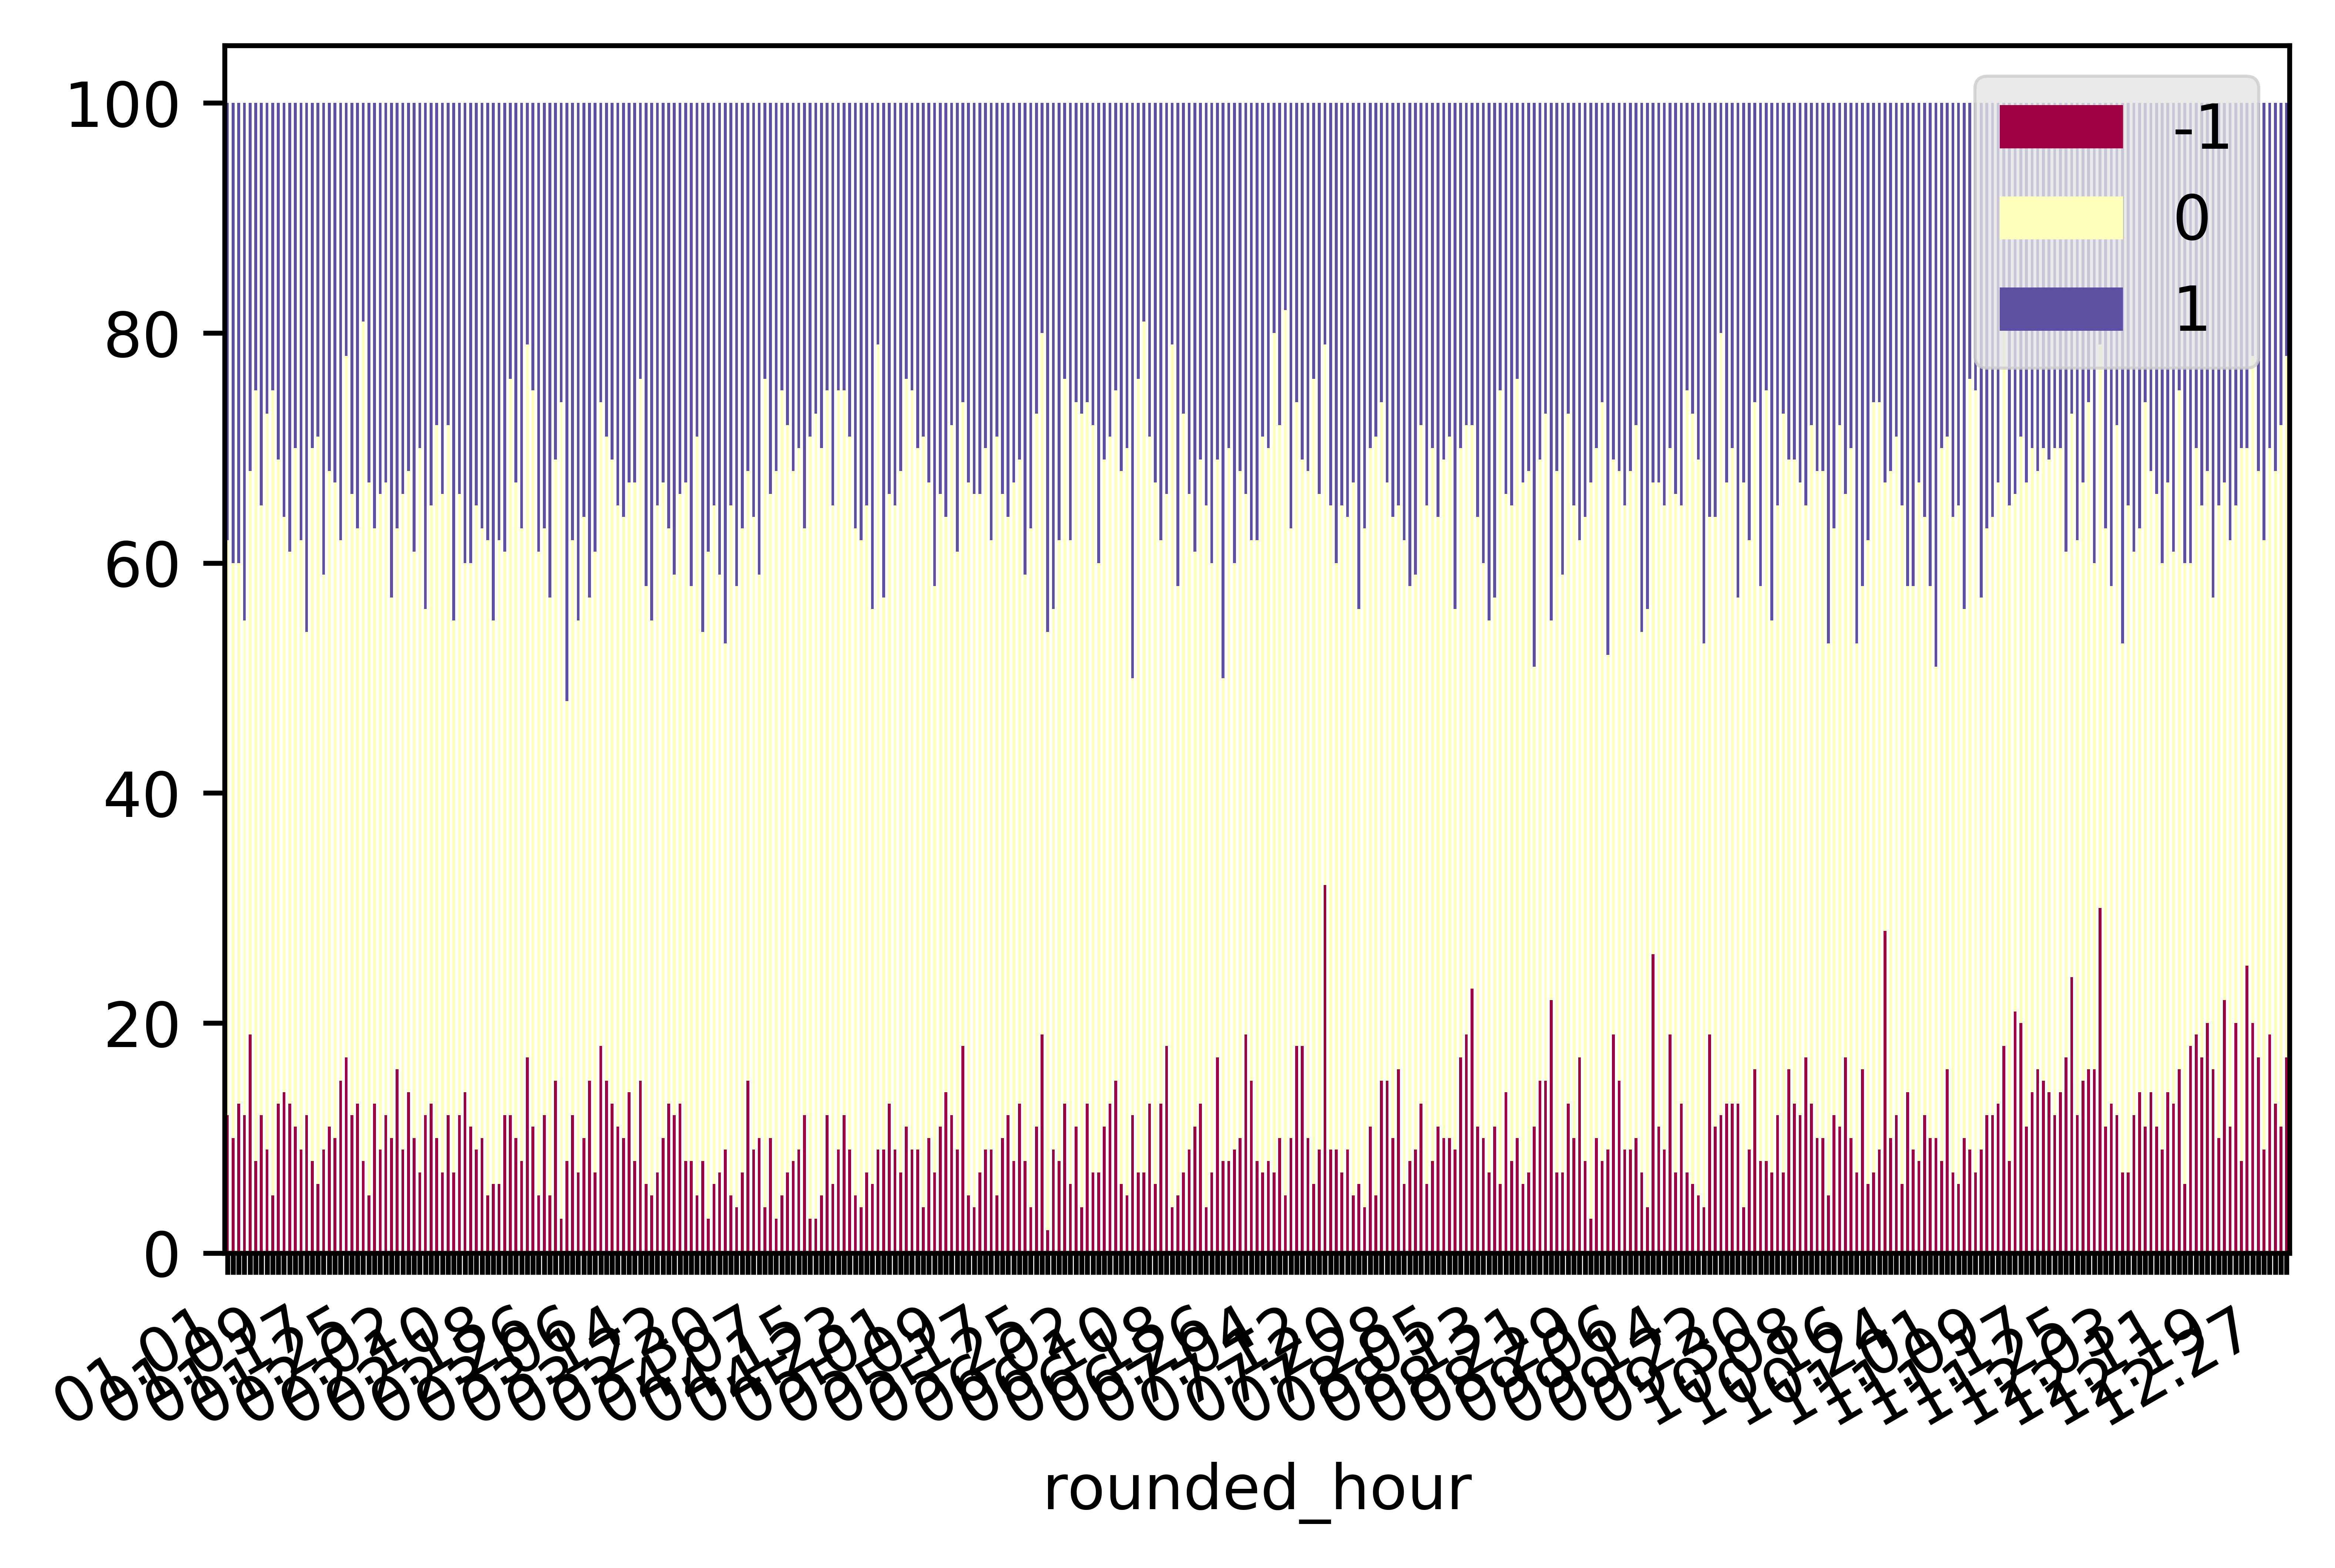

In [10]:
plot_stacked_bar(S3_pivot, 'rounded_hour', 'SA')

In [11]:
# save to csv
S3.to_csv('S3_2018.csv', index=False)